# Import

In [26]:
import os
from sys import stdout
import re
from io import StringIO 
import numpy as np
from numpy import mean, sqrt, absolute
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
plt.style.use('seaborn-deep')
# plt.subplot_tool()

from pysptools import spectro as sp
from math import log, e, exp

from sklearn import preprocessing, datasets, metrics, svm, linear_model
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import model_selection
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, StratifiedKFold, cross_val_score 
from sklearn.model_selection import RepeatedKFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor

from scipy.signal import savgol_filter, find_peaks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor, plot_importance


from __future__ import print_function
import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp

import spectres
import pickle

from tqdm.notebook import tqdm
import time

from joblib import Parallel, delayed
from IPython.display import display

from pprint import pprint

# %load_ext jupyternotify

# Class

In [20]:
class spectra_processing: 
    
    def __init__(self, df):
        self.df = df
                       
    def mean_centering(self):
        df_center = self.df.sub(self.df.mean(axis=1), axis=0)
        return df_center
    
    def ContinuumRemoval(self):
        index_df = self.df.index.tolist()
        CR_values = []
        df1 = self.df.reset_index()
        df1.drop(columns='sample', inplace=True)
        for sample in df1.index.tolist():
            convex_hull = (sp.convex_hull_removal(df1.loc[sample,:],df1.loc[:,:].columns.tolist()))
            CR_values.append(convex_hull[0])
        CR_df = pd.DataFrame(data=CR_values, index=df.index.tolist(), columns=df1.loc[:,:].columns.tolist())
        CR_df.columns = [float(i) for i in self.df.columns.tolist()]
        return CR_df 

    def savgol(self,window_length=7,poly_order=2,drv=1):
        self.window_length = window_length; self.poly_order = poly_order ; self.drv= drv
        col = list(self.df.columns)
        idx = list(self.df.index)
        df = savgol_filter(self.df ,window_length ,poly_order, deriv=drv)
        df  = pd.DataFrame(self.df , columns = col, index = idx)
        return df 
    
    def spec_range(self, start, end):
        sel.start = start ; self.end = end
        df = self.df.loc[:,start:end]
        return df
  
    def absorb_bands_rf(self ,y, prom_val):
        self.y =y ; self.prom_val = prom_val
        all_waves=[]
        for idx in df.index:
            row = self.df.loc[idx]
            waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
            all_waves.append(list(waves + self.df.columns[0]-1))   
        relevant_waves = list({x for l in all_waves for x in l})
        relevant_waves.sort()
        x_absorb = self.df[relevant_waves]
        Y = y.loc[x_absorb.index]
        return (x_absorb, Y)       
    

In [24]:
lab = spectra_processing(lab)
lab_mc = lab.mean_centering()
# lab_mc

AttributeError: 'spectra_processing' object has no attribute 'sub'

In [23]:
lab

# functions

In [33]:
def ContinuumRemoval(X):
    index_df = X.index.tolist()
    CR_values = []
    df1 = X.reset_index()
    df1.drop(columns='sample', inplace=True)
    for sample in df1.index.tolist():
        convex_hull = (sp.convex_hull_removal(df1.loc[sample,:],df1.loc[:,:].columns.tolist()))
        CR_values.append(convex_hull[0])

    CR_df = pd.DataFrame(data=CR_values, index=df.index.tolist(), columns=df1.loc[:,:].columns.tolist())
    CR_df.columns = [float(i) for i in X.columns.tolist()]
    return CR_df

def savgol(X,window_length,poly_order,drv):
    col = list(X.columns)
    idx = list(X.index)
    X = savgol_filter(X,window_length,poly_order,deriv=drv)
    X = pd.DataFrame(X, columns = col, index = idx)
    return X

# Data Load

In [278]:
df_fld = pd.read_excel('01_INFI_SLL_OFICIAL_ALL_IR_CORRECTED.xlsx', index_col=0, sheet_name='fld')
df_lab = pd.read_excel('01_INFI_SLL_OFICIAL_ALL_IR_CORRECTED.xlsx', index_col=0, sheet_name='lab')

In [279]:
## select only the osotive IR values
fld = df_fld[df_fld['ir']>0]
lab = df_lab[df_lab['ir']>0] 
ir = lab['ir']

# Data processing

## IR

### Standartization (Y)

In [113]:
## samples that fall inside 3 SD
scaler = StandardScaler()
ir_arr = ir.values.reshape(-1,1)
ir_scaled = scaler.fit_transform (ir_arr).flatten()
ir_sd = pd.Series(ir_scaled, index = ir.index)
ir_std = ir_sd[(ir_sd>=-3) & (ir_sd<=3)]

fld = fld.loc[ir_std.index]
lab = lab.loc[ir_std.index]
ir = lab['ir']

### log IR (Y data)

In [280]:
y_log = ir.map(lambda x: log(x))
# y_log = ir.map(lambda x: log(x*3600))

<IPython.core.display.Javascript object>


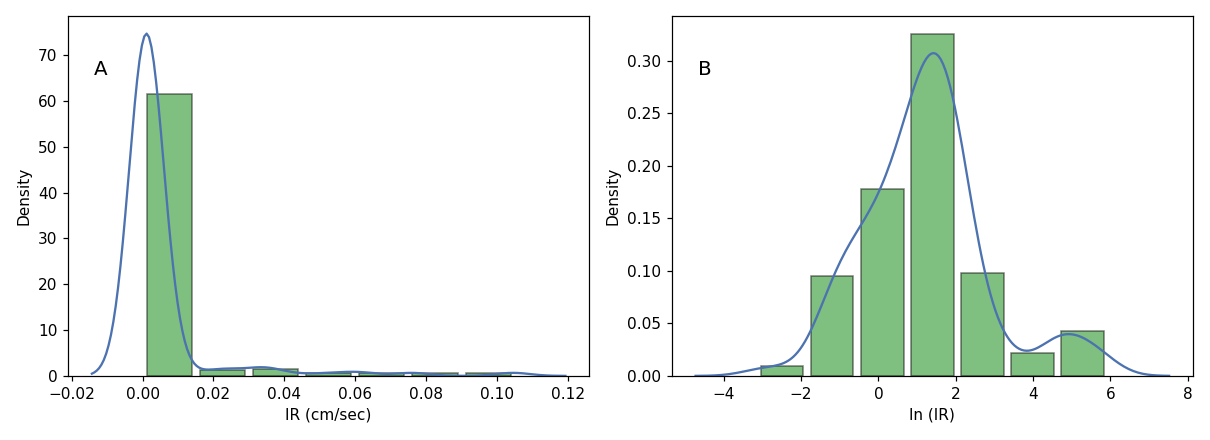

C:\Users\efrati\.conda\envs\bar\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\efrati\.conda\envs\bar\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [110]:
# # plot the distribution of IR before % after applying log

# fig, ax = plt.subplots(1, 2, figsize=(11,4), sharey=False)

# sns.distplot(ax=ax[0], x=ir, bins=7, hist_kws={"rwidth":.85,'edgecolor':'black', 'alpha':0.5, 'color':'green'})
# ax[0].text(0.05, 0.88, 'A' , transform = ax[0].transAxes, fontsize =13, verticalalignment = 'top')
# ax[0].set_xlabel('IR (cm/sec)')
# sns.distplot(ax=ax[1], x=y_60, bins=7, hist_kws={"rwidth":.85,'edgecolor':'black', 'alpha':0.5,'color':'green'})
# ax[1].text(0.05, 0.88, 'B' , transform = ax[1].transAxes, fontsize =13, verticalalignment = 'top')
# ax[1].set_xlabel('ln (IR)')
# plt.tight_layout()
# # plt.savefig(r'C:\Users\efrati\Desktop\Master\proposal\ir_distrebution.jpeg', dpi=200)

## spectra 

### Chose the spectral range

In [281]:
# select the required bands from the df

x_fld = fld.loc[:,450:2350]
x_lab = lab.loc[:,450:2450]

########    for AVIRIS     #######
# X_fld = fld.loc[:,np.r_[480:1801,2109:2249]]
# X_lab = lab.loc[:,480:1800]
# X_lab = lab.loc[:,np.r_[480:1801,2109:2249]

### Continuum Removal

In [8]:
# appply contiuum removal

# x_cr = ContinuumRemoval(x_lab)
# x_cr.T.plot(legend=None)

### Centering data

In [282]:
# centering the data by substracting the mean from the spectrum 
df_to_center = x_lab
center_sub = df_to_center.sub(df_to_center.mean(axis=1), axis=0)
# fig, ax = plt.subplots(1,3, figsize = (20,5))
# center_sub.T.plot(ax = ax[1], legend=None)
# df_to_center.T.plot(ax = ax[0], legend=None)
# center_sub.iloc[30].T.plot(ax = ax[2], label = 'Mean Centering',style ='k-')
# df_to_center.iloc[30].T.plot(ax = ax[2], label = 'Raw (Reflectance)', style ='-.', color = 'maroon')
# ax[2].legend(loc = 'lower right', fontsize = 14)
# ax[0].set_xlabel('Wavelength (nm)', fontsize = 15)
# ax[1].set_xlabel('Wavelength (nm)', fontsize = 15)
# ax[2].set_xlabel('Wavelength (nm)', fontsize = 15)
# ax[0].set_ylabel('Reflectance', fontsize = 15)
# ax[1].set_ylabel('Reflectance - mean', fontsize = 15)
# ax[2].set_ylabel('Mean | Reflectance', fontsize = 15)
# plt.tight_layout(pad=0.4, w_pad=2, h_pad=2.5)
# ax[0].text(0.05, 0.88, 'A' , transform = ax[0].transAxes, fontsize =15, verticalalignment = 'top')
# ax[1].text(0.05, 0.88, 'B' , transform = ax[1].transAxes, fontsize =15, verticalalignment = 'top')
# ax[2].text(0.05, 0.88, 'C' , transform = ax[2].transAxes, fontsize =15, verticalalignment = 'top')
# ax[0].tick_params(axis='both', which='major', labelsize=13)
# ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[2].tick_params(axis='both', which='major', labelsize=13)
# plt.subplot_tool()
# plt.savefig(r'C:\Users\efrati\Desktop\Master\proposal\raw_vs_mean_cntr.jpg', dpi=250)

### Smoothing Sav-Gol

<IPython.core.display.Javascript object>


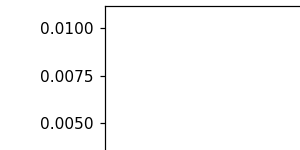

In [283]:
# smoothing the spectra by savgol filter
x_svg = savgol(center_sub,11,2,1)
fig, ax = plt.subplots(1,2, figsize = (12,4))
x_svg.T.plot(legend=None, ax=ax[0] )#, title = 'Sav-Gol filter, 1st derivative')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Derivative')
x_svg.iloc[50].T.plot(legend=None, ax=ax[1] )#, title = 'Sav-Gol filter, 1st derivative')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Derivative')
# ax[1].plot(np.arange(480,2400,1), 0)
ax[1].axhline(y=0, color='r', linestyle='-.', alpha = 0.5)
plt.tight_layout(pad=0.4, w_pad=2, h_pad=2.5)
# ax[0].text(0.02, 0.88, 'A' , transform = ax[0].transAxes, fontsize =15, verticalalignment = 'top')
# ax[1].text(0.02, 0.88, 'B' , transform = ax[1].transAxes, fontsize =15, verticalalignment = 'top')
# ax[1].set_ylim(-.005,0.01)
# plt.savefig(r'C:\Users\efrati\Desktop\Master\proposal\derivative.jpg', dpi=300)

### find peaks

<IPython.core.display.Javascript object>


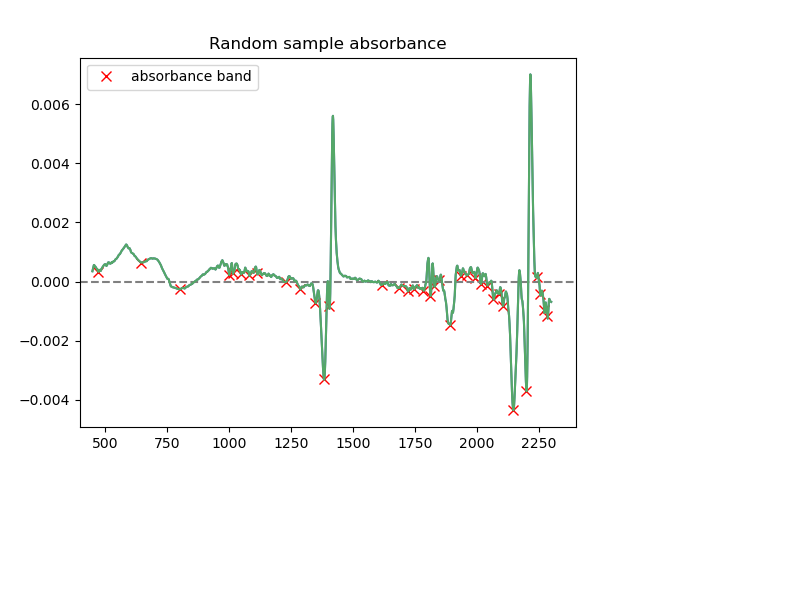

In [86]:
## Function that finds the absorbance bands in each spectrum   

# fig,ax = plt.subplots()
# random_sample = x_svg.loc['bar_1']
# peaks, _ = find_peaks(-1*random_sample, height=-2, distance=10, prominence=(0.0001))
# plt.plot(random_sample)
# peaks = peaks+449
# plt.plot(peaks, random_sample.loc[peaks], "x", label = 'absorbance band', markersize=7, color='r')
# plt.hlines(0,400,2400,color="gray", linestyles='dashed')
# plt.xlim(400,2400)
# plt.title('Random sample absorbance')
# plt.legend()
# plt.show()

# all_waves = []
# prom_val = 0.00035
# for idx in x_svg.index:
#     row = x_svg.loc[idx]
#     waves, k = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
#     waves = list(waves + 449)
#     all_waves.append(waves)

# relevant_waves = list({x for l in all_waves for x in l})
# relevant_waves.sort()
# x_peak = x_svg[relevant_waves]


In [10]:
#  this section takes the minimal features  
# d_peak={}
# d_prominence= {}
# for idx in x_svg.index:
#     row = x_svg.loc[idx]
#     waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=(0.000005))
#     waves = waves + 469
#     d_prominence= {}
#     for ref, prom in zip(x_svg.loc[idx][waves],param['prominences']):
#         d_prominence[ref]= prom
#     d_peak[idx] = d_prominence
    
# # find the top pronicence values

# n_features = None
# for key, val in d_peak.items():
#     n_features = len(val)
# for key, val in d_peak.items():
#     if len(val)< n_features:
#         n_features=len(val)
#     else:
#         n_features=n_features

# final_d = {}
# for idx, inner_dict in d_peak.items():
#     sorted_dict = {k: v for k, v in sorted(inner_dict.items(), key=lambda item: item[1])}
#     top_val = list(sorted_dict.keys())[:n_features]
#     final_d[idx] = top_val

# x_peak = pd.DataFrame.from_dict(final_d).T
# x_peak.columns = ['feature_'+str(i) for i in range(1,n_features+1)]

# Models

## PLSR

In [124]:
x_bar = x_svg.loc['bar_1':]
# x_bar = x_svg.loc[:]

Y = y_log.loc[x_bar.index]

print('Y shape: ', Y.shape)
print('X shape: ', x_bar.shape)

Y shape:  (147,)
X shape:  (147, 1901)


In [125]:
#####  working  ########

# this fuction choses the specific wavelength for the model, with prominence, n_splits and n_component

def absorb_bands(df, y, prom_val, comp, fold):
    
    avg_r2_v_inner_loop = []
    avg_rmse_v_inner_loop = []
    avg_r2_c_inner_loop = []
    avg_rmse_c_inner_loop = []
    
    all_waves=[]
    
    for idx in df.index:
        row = df.loc[idx]
        waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
        waves = list(waves + df.columns[0]-1)    
        all_waves.append(waves)
    relevant_waves = list({x for l in all_waves for x in l})
    relevant_waves.sort()
    x_absorb = df[relevant_waves]
    Y = y.loc[x_absorb.index]

     ################################

    kf = RepeatedKFold(n_splits=fold, n_repeats=n_repeats, random_state=None)
    for train_index , test_index in kf.split(x_absorb):
        X_train , X_test = x_absorb.iloc[train_index,:] ,x_absorb.iloc[test_index,:]
        y_train , y_test = Y[train_index] , Y[test_index]
        pls = PLSRegression(n_components=comp)
        pls.fit(X_train,y_train)
        
        ### Calibration ###
        y_hat_calibration = pls.predict(X_train)
        r2_calibration = float(r2_score(y_train,y_hat_calibration))
        rmse_calibration = np.sqrt(mean_squared_error(y_train,y_hat_calibration))
        avg_r2_c_inner_loop.append(r2_calibration)
        avg_rmse_c_inner_loop.append(rmse_calibration)
        
        #### validation ###    
        y_hat_validation = pls.predict(X_test)
        r2_validation = float(r2_score(y_test,y_hat_validation))
        rmse_validation = np.sqrt(mean_squared_error(y_test,y_hat_validation))
        avg_r2_v_inner_loop.append(r2_validation)
        avg_rmse_v_inner_loop.append(rmse_validation)
        
    avg_r2_v = sum(avg_r2_v_inner_loop)/(fold*n_repeats)
    avg_rmse_v = sum(avg_rmse_v_inner_loop)/(fold*n_repeats)   
    
    avg_r2_c = sum(avg_r2_c_inner_loop)/(fold*n_repeats)
    avg_rmse_c = sum(avg_rmse_c_inner_loop)/(fold*n_repeats)
    
    return (avg_r2_v,avg_rmse_v,avg_r2_c,avg_rmse_c, len(x_absorb.columns), all_waves )

In [126]:
from joblib import Parallel, delayed
from IPython.display import display

def process(prom, fold, comp, x_bar, Y):
    r2_val, rmse_val,r2_cal, rmse_cal, n_waves, waves = absorb_bands(x_bar, Y, prom, comp, fold)
    return (prom,n_waves,waves, fold, comp, r2_val, rmse_val,r2_cal, rmse_cal)

scores = []
n_splits= np.arange(3,11) 
n_components = np.arange(4,15) 
prom_val = np.arange(0.0001,0.0006,0.00005) 
n_repeats = 20
params = []
for prom in prom_val:
    for fold in n_splits:
        for comp in n_components:
            params.append((prom, fold, comp, x_bar, Y))
        
            
scores = Parallel(n_jobs=-1)(delayed(process)(*i) for i in params)

In [127]:
df_results = pd.DataFrame(scores, columns =['prom','n_waves','waves', 'splits', 'comp', 'r2_val','rmse_val','r2_cal','rmse_cal'])
df_results.sort_values(by=['r2_val','r2_cal'], axis=0, ascending=False, inplace=True)

# writer = pd.ExcelWriter('PLSR_results_fld.xlsx', engine='xlsxwriter')
# df_results.to_excel(writer, sheet_name='results', index=False)
# writer.save()
df_results

,prom,n_waves,waves,splits,comp,r2_val,rmse_val,r2_cal,rmse_cal
0,0.00010,1397,"[[472, 645, 801, 960, 1002, 1018, 1048, 1082, ...",3,4,0.650178,1.131674,0.854289,0.744213
11,0.00010,1397,"[[472, 645, 801, 960, 1002, 1018, 1048, 1082, ...",4,4,0.649984,1.128846,0.843865,0.772708
1,0.00010,1397,"[[472, 645, 801, 960, 1002, 1018, 1048, 1082, ...",3,5,0.645141,1.145917,0.906555,0.595870
22,0.00010,1397,"[[472, 645, 801, 960, 1002, 1018, 1048, 1082, ...",5,4,0.644282,1.117435,0.836694,0.790402
34,0.00010,1397,"[[472, 645, 801, 960, 1002, 1018, 1048, 1082, ...",6,5,0.640851,1.114650,0.885995,0.660739
...,...,...,...,...,...,...,...,...,...
340,0.00025,900,"[[472, 801, 1002, 1018, 1048, 1082, 1349, 1384...",9,14,0.108283,1.623848,0.989847,0.196415
791,0.00050,679,"[[801, 1002, 1384, 1406, 1723, 1813, 1891, 201...",10,14,0.104433,1.606582,0.983359,0.251785
603,0.00040,744,"[[801, 1002, 1018, 1349, 1384, 1406, 1723, 181...",9,13,0.104046,1.627888,0.982181,0.260331
867,0.00055,638,"[[801, 1384, 1406, 1723, 1813, 1891, 2106, 214...",9,13,0.102388,1.670163,0.978754,0.284826


In [ ]:
### working simple example ####
# t = time.time()

# scores = []
# n_splits= np.arange(3,11)
# n_components = np.arange(3,16) #13
# prom_val = np.arange(0.0001,0.0006,0.00005) #10
# # n_repeats = 30

# def absorb_bands(df,y, prom_val, comp, sp):
#     all_waves=[]
#     for idx in df.index:
#         row = df.loc[idx]
#         waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
#         waves = list(waves + df.columns[0]-1)    
#         all_waves.append(waves)
#     relevant_waves = list({x for l in all_waves for x in l})
#     relevant_waves.sort()
#     x_absorb = df[relevant_waves]
#     Y = y.loc[x_absorb.index]

# #     ################################
# #     kf = RepeatedKFold(n_splits=sp, n_repeats=30)

#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33)

# #     train_index , test_index = split(x_absorb)
# #     X_train , X_test = x_absorb.iloc[train_index,:] ,x_absorb.iloc[test_index,:]
# #     y_train , y_test = Y[train_index] , Y[test_index]
    
#     pls = PLSRegression(n_components=comp)
#     pls.fit(X_train,y_train)
#     y_hat = pls.predict(X_test)
#     ##### results #######
#     r2 = r2_score(y_test,y_hat)
#     rmse = np.sqrt(mean_squared_error(y_test,y_hat))
#     return (r2,rmse)

# count=0 
# for prom in prom_val:
# #     print('prom',prom)
#     for sp in n_splits:
# #         print('sp',sp)
#         for comp in n_components:
#             count=count+1
# #             print('comp',comp)
#             r2, rmse = absorb_bands(x_svg, y_log, prom, comp, sp)
#             val = [prom, sp, comp, r2,rmse]
#             scores.append(val)    
            
# elapsed = time.time() - t
# print(count)
# print(scores) 

## random forest

In [284]:
x_bar = x_svg.loc['bar_1':]
Y = y_log.loc[x_bar.index]

print('Y shape: ', Y.shape)
print('X shape: ', x_bar.shape)

Y shape:  (147,)
X shape:  (147, 2001)


In [285]:
def absorb_bands_rf(df,y, prom_val):  
    all_waves=[]
    for idx in df.index:
        row = df.loc[idx]
        waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
        waves = list(waves + df.columns[0]-1)    
        all_waves.append(waves)
    relevant_waves = list({x for l in all_waves for x in l})
    relevant_waves.sort()
    x_absorb = df[relevant_waves]
    Y = y.loc[x_absorb.index]
    return (x_absorb, Y)     

In [286]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 80, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 5, num = 5)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

d_result = {}
prom_val = np.arange(0.0001,0.0006,0.00001)
for prom in tqdm(prom_val):
    df, y = absorb_bands_rf(x_bar, Y, prom)
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=None)
#     X_test, X_val, y_test, y_val = train_test_split(XX_test, yy_test, test_size=0.5, random_state=None)
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(
                                   estimator = rf, 
                                   param_distributions = random_grid, 
                                   n_iter = 30, #100
                                   cv = 3, 
                                   verbose=0, 
                                   random_state=None, 
                                   n_jobs = -1
                                    )
    rf_random.fit(X_train,y_train)
    best_params = rf_random.best_params_
    waves = list(df.columns)
       
    ### Calibration ###
    y_hat_calibration = rf_random.predict(X_train)
    r2_calibration = float(r2_score(y_train,y_hat_calibration))
    rmse_calibration = np.sqrt(mean_squared_error(y_train,y_hat_calibration))


    #### validation ###    
    y_hat_test = rf_random.predict(X_test)
    r2_test = float(r2_score(y_test,y_hat_test))
    rmse_test = np.sqrt(mean_squared_error(y_test,y_hat_test))
    

    d_result[prom] = [r2_calibration, rmse_calibration, r2_test, rmse_test, best_params, waves]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\efrati\.conda\envs\bar\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\efrati\.conda\envs\bar\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\efrati\.conda\envs\bar\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default va

In [297]:
df_results_rf = pd.DataFrame.from_dict(d_result, orient='index')
df_results_rf.columns = ['r2_cal', 'rmse_cal', 'r2_test', 'rmse_test', 'best_params', 'waves']
df_results_rf.sort_values(by=['r2_test','r2_cal'], axis=0, ascending=False, inplace=True)
df_results_rf.index.rename('prom_val', inplace=True)
df_results_rf = pd.concat([df_results_rf,df_results_rf['best_params'].apply(pd.Series)], axis=1)
df_results_rf.drop(['best_params'], axis=1, inplace=True)
# df_results_rf.to_csv('rf_results_lab.csv')
df_results_rf

,r2_cal,rmse_cal,r2_test,rmse_test,waves,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
prom_val,,,,,,,,,,,
0.00019,0.894200,0.627029,0.811508,0.871410,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",37,5,3,sqrt,4,False
0.00055,0.800391,0.819549,0.802868,1.018019,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",71,7,3,auto,3,True
0.00023,0.805237,0.812789,0.802672,1.014183,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",71,7,3,auto,3,True
0.00029,0.878067,0.700058,0.774883,0.861833,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",62,10,2,sqrt,4,False
0.00053,0.838452,0.778615,0.757093,0.991748,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",71,10,2,auto,4,True
0.00039,0.893590,0.622618,0.753327,1.052378,"[457, 458, 459, 463, 464, 465, 469, 471, 472, ...",28,5,2,sqrt,4,False
0.00057,0.856690,0.714601,0.751477,1.078543,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",20,7,2,auto,5,True
0.00047,0.813164,0.842413,0.735666,0.994993,"[463, 465, 472, 474, 480, 656, 657, 658, 796, ...",71,2,2,auto,3,True
0.00017,0.838209,0.802083,0.714807,0.998658,"[457, 458, 459, 462, 463, 464, 465, 466, 467, ...",71,10,3,sqrt,3,False


In [267]:
parameters = {'prom_val':df_results_rf.index[0], 
              'n_estimators':df_results_rf.iloc[0]['n_estimators'], 
              'min_samples_leaf': df_results_rf.iloc[0]['min_samples_leaf'],
              'max_features': df_results_rf.iloc[0]['max_features'], 
              'max_depth': df_results_rf.iloc[0]['max_depth'], 
            'bootstrap': df_results_rf.iloc[0]['bootstrap']
             }
rf_param = { 'min_samples_leaf': df_results_rf.iloc[0]['min_samples_leaf'],
              'max_features': df_results_rf.iloc[0]['max_features'], 
              'max_depth': df_results_rf.iloc[0]['max_depth'], 
            'bootstrap': df_results_rf.iloc[0]['bootstrap']
             }

### apply model on nicolas data

In [268]:
x_nicolas = x_svg.loc[:'bar_1']
y_nicolas = y_log.loc[x_nicolas.index]

print('y_nicolas: ', y_nicolas.shape)
print('x_nicolas: ', x_nicolas.shape)

y_nicolas:  (105,)
x_nicolas:  (105, 2001)


In [296]:
avg_r2 = []
avg_rmse = []
for i in range(30):
    
    d_result_nicolas={}
    df, y = absorb_bands_rf(x_nicolas, y_nicolas, parameters['prom_val'])
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=None)
    rf = RandomForestRegressor(**rf_param)                                                             
    rf.fit(X_train,y_train)

    #### validation ###    
    y_hat_test = rf.predict(X_test)
    avg_r2.append(float(r2_score(y_test,y_hat_test)))
    avg_rmse.append(np.sqrt(mean_squared_error(y_test,y_hat_test)))

d_result_nicolas['score'] = [sum(avg_r2)/30, sum(avg_rmse)/30]

In [297]:
d_result_nicolas

{'score': [0.1663045883181848, 0.734941863905579]}

In [293]:
# working simple RF model 
k=3 # n_splits
repeats = 3
estimators = 100 # n_estimators

kf = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=None)

rf = RandomForestRegressor(n_estimators=726)
avg_r2 = []
avg_rmse = []

for train_index , test_index in tqdm(kf.split(x_svg)):
    X_train , X_test = x_svg.iloc[train_index,:] ,x_svg.iloc[test_index,:]
    y_train , y_test = y_log[train_index] , y_log[test_index]

    
    rf.fit(X_train,y_train)
    pred_values = rf.predict(X_test)
    r2 = float(r2_score(y_test,pred_values))
    avg_r2.append(r2)
    
    rmse = np.sqrt(mean_squared_error(y_test,pred_values))
    avg_rmse.append(rmse) 


avg_r2 = sum(avg_r2)/(k*repeats)
avg_rmse = sum(avg_rmse)/(k*repeats)

print('avg_r2: ', round(avg_r2,2))
print('avg_rmse: ', round(avg_rmse,2))

####################################################
# model = RandomForestRegressor(n_estimators=300)
# model.fit(X_train, y_train)
# tree_predictions = model.predict(X_test)

0it [00:00, ?it/s]

KeyboardInterrupt: 

## SVM

In [288]:
x_bar = x_svg.loc['bar_1':]
Y = y_log.loc[x_bar.index]

print('Y shape: ', Y.shape)
print('X shape: ', x_bar.shape)

Y shape:  (147,)
X shape:  (147, 2001)


In [289]:
rbf = {'C' : np.arange(1,11,1), 'gamma': np.arange(10,100,5)}
linear = {'C': np.logspace(-2, 10, 13)}
poly = {'degree': np.linspace(1,8, num=6),'gamma': np.logspace(-9, 3, 20)}

svr_models = [rbf, linear, poly]
# kernel_label = ["RBF", "Linear", "Polynomial"]

In [290]:
def absorb_bands_svm(df,y, prom_val):  
    all_waves=[]
    for idx in df.index:
        row = df.loc[idx]
        waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
        waves = list(waves + df.columns[0]-1)    
        all_waves.append(waves)
    relevant_waves = list({x for l in all_waves for x in l})
    relevant_waves.sort()
    x_absorb = df[relevant_waves]
    Y = y.loc[x_absorb.index]
    return (x_absorb, Y)     

In [291]:
d_results_svr = {}
prom_val = np.arange(0.0001,0.001,0.00001)
for prom in tqdm(prom_val):
    df, y = absorb_bands_svm(x_bar, Y, prom)
    waves = list(df.columns)
    length = len(waves)   
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=None)    
#     for model in svr_models:
    SVM_grid = RandomizedSearchCV(
                               estimator = SVR(kernel = 'rbf'),
                               param_distributions = rbf,
                               n_iter = 30,
                               cv = 3,
                               verbose=0, 
                               random_state=None, 
                               n_jobs = -1
                                )
    SVM_grid.fit(X_train,y_train)
    best_params = SVM_grid.best_params_
    n_waves=len(waves)
    y_cal = SVM_grid.predict(X_train)
    y_val = SVM_grid.predict(X_test)
    r2_cal = r2_score(y_train, y_cal)
    r2_val = r2_score(y_test, y_val)
    rmse_cal = mean_squared_error(y_train, y_cal, squared=True)
    rmse_val = mean_squared_error(y_test, y_val, squared=True)
    d_results_svr[prom] = [r2_cal, r2_val, rmse_cal, rmse_cal, best_params, n_waves, waves]    

  0%|          | 0/90 [00:00<?, ?it/s]

In [292]:
df_results_svm = pd.DataFrame.from_dict(d_results_svr, orient='index')
df_results_svm.columns = ['r2_cal', 'r2_val', 'rmse_cal', 'rmse_cal', 'best_params', 'n_waves', 'waves']
df_results_svm.sort_values(by=['r2_val','r2_cal'], axis=0, ascending=False, inplace=True)
df_results_svm.index.rename('prom_val', inplace=True)
df_results_svm = pd.concat([df_results_svm,df_results_svm['best_params'].apply(pd.Series)], axis=1)
df_results_svm.drop(['best_params'], axis=1, inplace=True)
# df_results_svm.to_csv('svm_results_fld.csv')
df_results_svm

,r2_cal,r2_val,rmse_cal,rmse_cal,n_waves,waves,gamma,C
prom_val,,,,,,,,
0.00013,0.089374,0.128428,3.799819,3.799819,313,"[457, 458, 459, 462, 463, 464, 465, 466, 467, ...",95,10
0.00049,0.072450,0.117943,3.800999,3.800999,109,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",95,10
0.00081,0.045658,0.116578,3.671433,3.671433,73,"[658, 796, 798, 799, 801, 812, 813, 818, 1349,...",80,10
0.00022,0.102497,0.115666,3.368948,3.368948,225,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",95,10
0.00082,0.077495,0.111807,3.916659,3.916659,73,"[658, 796, 798, 799, 801, 812, 813, 818, 1349,...",90,9
...,...,...,...,...,...,...,...,...
0.00062,0.145824,-0.116849,3.567913,3.567913,92,"[472, 480, 657, 658, 796, 798, 799, 801, 810, ...",95,10
0.00058,0.086292,-0.128656,3.666498,3.666498,99,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",85,10
0.00084,0.045568,-0.178656,3.858724,3.858724,72,"[658, 796, 798, 799, 801, 812, 813, 818, 1349,...",75,10


## XGboots

In [293]:
def absorb_bands_xgboots(df,y, prom_val):  
    all_waves=[]
    for idx in df.index:
        row = df.loc[idx]
        waves, param = find_peaks(-1*row, height=-2, distance=10, prominence=prom_val)
        waves = list(waves + df.columns[0]-1)    
        all_waves.append(waves)
    relevant_waves = list({x for l in all_waves for x in l})
    relevant_waves.sort()
    x_absorb = df[relevant_waves]
    Y = y.loc[x_absorb.index]
    return (x_absorb, Y)     

In [294]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 30, num = 8)]
# max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 5, num = 3)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [2,3]
grow_policy = [0,1]
subsample = [0.5, 0.6 ,0.7, 0.8] # fraction of observations to be sampled for each tree
learning_rate = [float(x) for x in np.linspace(0.01,0.3, num= 6)] # determines the step size at each iteration while your model optimizes toward its objective
colsample_bytree = [0.5, 0.6 ,0.7, 0.8] # fraction of columns to be randomly sampled for each tree
colsample_bylevel = [0.5, 0.6]
min_child_weight = [1,10,50,100]
gamma = [5,10,30]
booster= ['gbtree', 'gblinear','dart']

params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'subsample':subsample,
               'learning_rate':learning_rate,
               'colsample_bytree':colsample_bytree,
               'colsample_bylevel':colsample_bylevel,
               'min_child_weight':min_child_weight,
               'gamma':gamma,
               'booster':booster          
               }

In [295]:
d_results_xg = {}
prom_val = np.arange(0.0001,0.0006,0.00001)
for prom in tqdm(prom_val):
    df, y = absorb_bands_rf(x_bar, Y, prom)
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=None)
    xg_reg = XGBRegressor()
    xg_reg_grid = RandomizedSearchCV(
                                   estimator = xg_reg, 
                                   param_distributions = params, 
                                   n_iter = 30, #100
                                   cv = 3, 
                                   verbose=1, 
                                   random_state=None, 
                                   n_jobs = -1
                                    )
    xg_reg_grid.fit(X_train,y_train) # early_stopping=10,verbos=True)
    best_params = xg_reg_grid.best_params_
    waves = list(df.columns)
    n_waves=len(waves)
    y_cal = xg_reg_grid.predict(X_train)
    y_val = xg_reg_grid.predict(X_test)
    r2_cal = r2_score(y_train, y_cal)
    r2_val = r2_score(y_test, y_val)
    rmse_cal = mean_squared_error(y_train, y_cal, squared=True)
    rmse_val = mean_squared_error(y_test, y_val, squared=True)
    d_results_xg[prom] = [r2_cal, r2_val, rmse_cal, rmse_cal, best_params, n_waves, waves]
    

  0%|          | 0/50 [00:00<?, ?it/s]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\efrati\.conda\envs\bar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [296]:
df_results_xg = pd.DataFrame.from_dict(d_results_xg, orient='index')
df_results_xg.columns = ['r2_cal', 'r2_val', 'rmse_cal', 'rmse_cal', 'best_params','n_waves', 'waves']
df_results_xg.sort_values(by=['r2_val','r2_cal'], axis=0, ascending=False, inplace=True)
df_results_xg.index.rename('prom_val', inplace=True)
df_results_xg = pd.concat([df_results_xg,df_results_xg['best_params'].apply(pd.Series)], axis=1)
df_results_xg.drop(['best_params'], axis=1, inplace=True)
# df_results_xg.to_csv('xg_result_lab.csv')
df_results_xg

,r2_cal,r2_val,rmse_cal,rmse_cal,n_waves,waves,subsample,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,colsample_bylevel,booster
prom_val,,,,,,,,,,,,,,,
0.00058,0.844848,0.813834,0.598875,0.598875,99,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",0.6,24,1,3,0.300,5,0.6,0.6,dart
0.00047,0.855032,0.754394,0.575869,0.575869,112,"[463, 465, 472, 474, 480, 656, 657, 658, 796, ...",0.7,18,10,5,0.300,5,0.6,0.5,dart
0.00046,0.834170,0.752013,0.548436,0.548436,118,"[459, 463, 464, 465, 471, 472, 474, 477, 480, ...",0.7,21,10,4,0.300,5,0.7,0.5,gbtree
0.00022,0.875958,0.729032,0.490560,0.490560,225,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",0.6,30,1,4,0.242,5,0.6,0.5,dart
0.00020,0.869421,0.723354,0.482582,0.482582,243,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",0.8,21,10,5,0.300,5,0.7,0.6,dart
0.00015,0.835637,0.717093,0.612912,0.612912,295,"[457, 458, 459, 462, 463, 464, 465, 466, 467, ...",0.5,18,1,3,0.242,5,0.7,0.5,dart
0.00055,0.842814,0.714055,0.609596,0.609596,101,"[472, 474, 480, 656, 657, 658, 796, 798, 799, ...",0.8,15,1,4,0.242,5,0.6,0.6,gbtree
0.00026,0.796441,0.694387,0.771936,0.771936,194,"[457, 458, 459, 463, 464, 465, 466, 467, 469, ...",0.6,24,10,3,0.300,10,0.8,0.5,gbtree
0.00012,0.862140,0.687084,0.513117,0.513117,324,"[457, 458, 459, 462, 463, 464, 465, 466, 467, ...",0.6,18,1,5,0.300,5,0.8,0.5,gbtree


# infi process

In [271]:
infi = pd.read_csv('infi_cluster.csv', index_col=0)
infi.dropna(axis=0, inplace=True)
infi = infi[infi['ir'] >0]

In [275]:
infi['cluster'] = infi['cluster'].map(lambda x: int(x))
infi['texture'] = infi['texture'].str.lower()
infi['ir'] = infi['ir']
infi

,lat,lon,ir,texture,cluster
sample,,,,,
bar_2,30.620723,34.847440,0.008202,sandy clay loam,31
bar_3,30.620723,34.847440,0.007245,sandy clay loam,31
bar_5,30.620449,34.847362,0.023096,sandy clay loam,32
bar_6,30.620402,34.847375,0.023312,sandy clay loam,32
bar_8,30.619670,34.847659,0.092838,sandy clay loam,33
...,...,...,...,...,...
bar_164,31.316745,34.559312,0.330844,silt loam,28
bar_165,31.316745,34.559126,0.001566,silt loam,28
bar_169,31.388604,34.452039,0.008422,silt loam,26


In [276]:
infi.groupby(['texture']).mean()

,lat,lon,ir,cluster
texture,,,,
clay loam,38.441477,19.972534,0.154500,27.250000
clayey,31.710986,34.908961,0.034445,16.857143
loam,31.422014,34.626839,0.017144,23.250000
loamy sand,32.069458,34.902048,0.100265,8.500000
sandy clay loam,33.642508,29.334077,0.486159,30.611111
sandy loam,36.749123,24.120591,1.658915,25.375000
silt loam,31.440408,34.633415,0.036765,23.217391
silty clay,34.379193,29.550292,0.067684,18.681818
silty clay loam,31.067260,35.371808,0.044501,29.500000


<IPython.core.display.Javascript object>


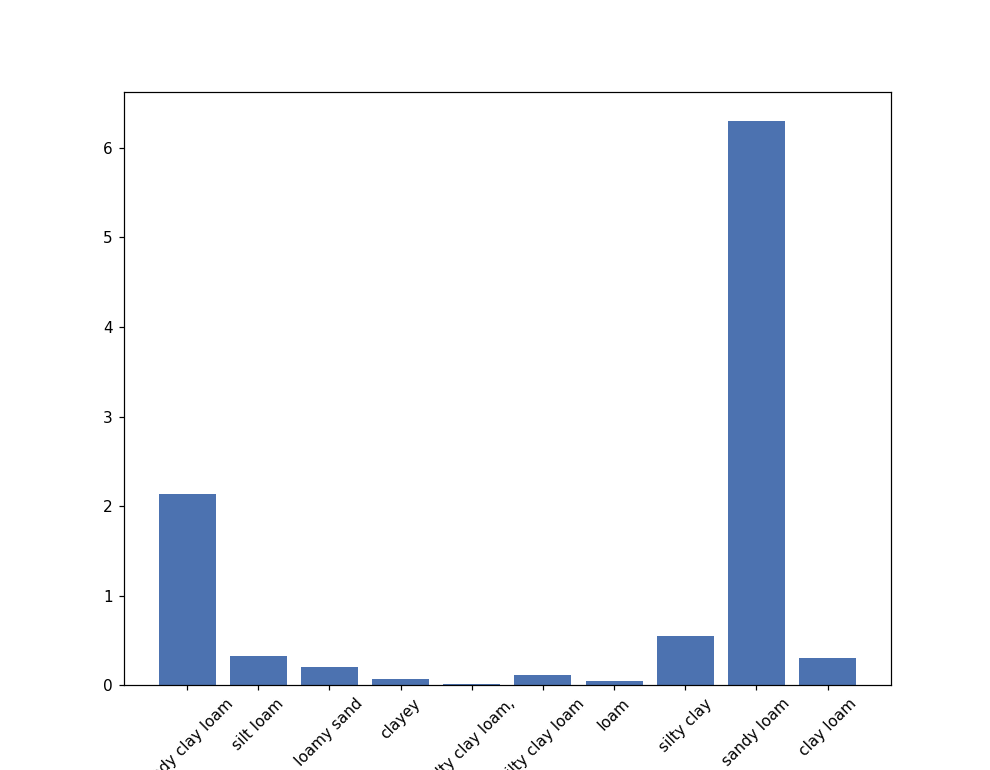

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [277]:
fig, ax = plt.subplots(figsize=(9,7))
ax.bar(infi['texture'], height=infi['ir'])
plt.xticks(rotation=45)

In [266]:
# infi['texture'].unique()